# MUSIC - calcul de la variance

## Algorithme MUSIC et détection de pics

### Quelques fonctions utiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
from scipy.sparse.linalg import eigsh
import random

In [2]:
def phase():
    # permet de générer une phase à l'origine aléatoire
    return random.uniform(0,2*np.pi)

In [3]:
def interpolation_max(x,y):
    # Pour une liste x de 3 abscisses et une liste y de 3 ordonnées 
    # renvoie l'abscisse du maximum de polynome de lagrange associé à ces points
    poly = lagrange(x,y)
    a = Polynomial(poly).coef
    return -a[1]/2/a[0]

Les fonctions suivantes suivent les notations de l'article. 

In [4]:
def etoile(A):
    return np.conjugate(A.T)

In [5]:
def J_l(m,l):
    J = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            if j == i + l :
                J[i][j] = 1
    return J

In [6]:
def A(m,p,omega):
    A = np.zeros((m,p),dtype=np.complex64)
    for i in range(m):
        for j in range(p):
            A[i][j] = np.exp(1j*i*omega[j])
    return A

### Fonction MUSIC

In [7]:
def MUSIC(N, m, p, signal):
    # N (int) : taille du signal
    # m (int) : nombre d'observations sur lesquelles on calcule la matrice d'autocorrélation
    # p (int) : nombre de fréquence à retrouver
    # signal (np.array) 

    M = N - m + 1
    
    def y(signal, t):
        # permet de calculer le vecteur colonne y
        y = np.zeros((m,1),dtype=np.complex64)
        for i in range(m):
            y[i] = signal[t + i]
        return y
    
    # on calcule la matrice d'autocorrélation du signal
    R = np.zeros((m,m),dtype=np.complex64)
    for i in range(M):
        R += y(signal,i)@etoile(y(signal,i))
    R = 1/M*R
    
    # décomposition spectrale de R avec lambda_signal les valeurs propres et vp les vecteurs propres
    lambda_signal, vp = np.linalg.eigh(R)
    
    # on réordonne les vecteurs propres et les valeurs propres de sorte que les valeurs propres sont dans l'ordre croissant
    ordre = np.argsort(lambda_signal)
    lambda_signal = np.take_along_axis(lambda_signal, ordre,axis=0)
    for i in range(m):
        vp[i] = np.take_along_axis(vp[i], ordre,axis=0)
    
    # on calcule la matrice S des vecteurs propres associées aux p plus grandes valeurs propres 
    S = vp[:,m-p:]
    matrice = np.eye(m)-S@etoile(S)
         

    def fonction_a(omega):
        # permet de calculer le vecteur colonne a associé à la fréquence omega
        return np.array([np.exp(1j*omega)**i for i in range(m)]).reshape(m,1)

    def spectre(omega):
        # fonction MUSIC
        res = etoile(fonction_a(omega))@matrice@fonction_a(omega)
        return 1/res[0,0].real
    
    return spectre

### Détection de pics

In [8]:
def detection_pic_music(f_music,fe,largeur_min_pic,resolution_freq,nb_pic):
    # f_music (fonction) : fonction music
    # fe (float) : fréquence d'échantillonage
    # largeur_min_pic (float) : largeur des pics 
    # resolution_freq (float) : taille de la plus petite fenêtre sur laquelle on cherche les pics de fréquence
    # nb_pic (int) : nombre de pics à chercher
    
    # on initialise une liste dans laquelle on stockera les plages dans lesquelles on a déjà trouvé un pic
    plage_interdite = []
    # initialisation de la liste qui contiendra les fréquences
    freq = []
    
    for i in range(nb_pic):
        fenetre = np.linspace(0,np.pi,1000)
        vraie_fenetre = np.copy(fenetre)
        potentiel_max = 0
        while fenetre[1] - fenetre[0] > resolution_freq/fe :
            #print(f'f_min = {fenetre[0]*fe} et f_max = {fenetre[-1]*fe}')
            spectre = np.zeros((1000))
            for i in range(1000) :
                spectre[i] = f_music(fenetre[i])
            for i in range(1000) :
                for plage in plage_interdite:
                    if plage[0] <= fenetre[i]*fe <= plage[1]:
                        spectre[i] = 0
            potentiel_max = np.argmax(spectre)
            vraie_fenetre = np.copy(fenetre)
            fenetre = np.linspace(fenetre[max(0,potentiel_max-50)],fenetre[min(999,potentiel_max+50)],1000)
        x = vraie_fenetre[potentiel_max-1:potentiel_max+2]
        y = [f_music(f) for f in x]
        frequence = interpolation_max(x,y)
        freq.append(frequence*fe)
        plage_interdite.append([frequence*fe-largeur_min_pic/2,frequence*fe+largeur_min_pic/2])
    return freq

### Exemple d'utilisation

Text(0.5, 0, 'Temps (en s)')

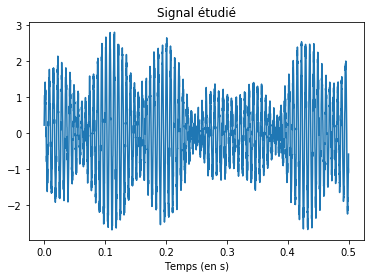

In [9]:
fe = 8064
N = int(fe*0.5)
m = 500
omega = np.array([940,958,880])
alpha = np.array([1/2,0.91/2,0.78/2])
sigma = 1/np.sqrt(50)
t = np.arange(N)/fe

signal = 2*alpha[0]*np.cos(omega[0]*t+phase())+2*alpha[1]*np.cos(omega[1]*t+phase())+2*alpha[2]*np.sin(omega[2]*t+phase()) + np.random.normal(0, sigma, N) 
plt.title('Signal étudié')
plt.plot(t, signal)
plt.xlabel('Temps (en s)')

In [10]:
music = MUSIC(N,m,6,signal)

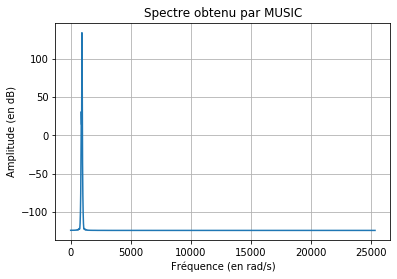

In [11]:
freq = np.linspace(0,np.pi,1000)
spectre = [20*np.log(music(f)) for f in freq]
plt.grid(True)
plt.title('Spectre obtenu par MUSIC')
plt.ylabel('Amplitude (en dB)')
plt.xlabel('Fréquence (en rad/s)')
plt.plot(freq*fe,spectre)

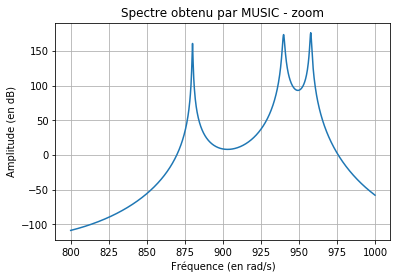

In [12]:
plt.grid(True)
freq = np.linspace(800/fe,1000/fe,1000)
spectre = [20*np.log(music(fr)) for fr in freq]
plt.title('Spectre obtenu par MUSIC - zoom')
plt.ylabel('Amplitude (en dB)')
plt.xlabel('Fréquence (en rad/s)')
plt.plot(freq*fe,spectre)

In [13]:
detection_pic_music(music,fe,10,0.01,3)

[957.7442018013138, 939.9137774672326, 880.0658646369872]

## Calcul de la variance

In [14]:
def var_theorique(N,m, p, A, P, sigma,fe):
    # N (int) : taille du signal
    # m (int) : nombre d'observations sur lesquelles on calcule la matrice d'autocorrélation
    # p (int) : nombre de fréquence à retrouver
    # A (np.array) : matrice A pour les fréquences
    # P (np.array) : matrice diagonale des amplitudes au carré (de taille pxp)
    # sigma (float) : racine carré de la variance du bruit
    # fe (float) : fréquence d'échantillonage (en Hz)
    
    R = A@P@etoile(A)+sigma**2*np.eye(m)
    B = A@np.linalg.inv(etoile(A)@A)
    d = np.zeros((m,p),dtype=np.complex64)
    M = N - m + 1
    for i in range(m):
        d[i] = 1j*i*A[i]
    lambda_signal, vp = np.linalg.eigh(R)
    ordre = np.argsort(lambda_signal)
    lambda_signal = np.take_along_axis(lambda_signal, ordre,axis=0)
    for i in range(m):
        vp[i] = np.take_along_axis(vp[i], ordre,axis=0)
    G = vp[:,:m-p]
    S = vp[:,m-p:]
    mu = G@etoile(G)@d
    C = np.zeros(p)
    for i in range(p):
        somme = 0
        hi = (etoile(d[:,i])@mu[:,i]).real
        for k in range(2*m-1):
            l = k - m + 1
            J = J_l(m,l)
            somme  += np.matmul(np.matmul(B[:,i].T,J),mu[:,i])*np.matmul(np.matmul(etoile(mu[:,i]),J),np.conjugate(B[:,i]))
            somme  += np.matmul(np.matmul(B[:,i].T,J),np.conjugate(mu[:,i]))*np.matmul(np.matmul(etoile(mu[:,i]),J),B[:,i])
            somme  += np.matmul(np.matmul(etoile(mu[:,i]),J),mu[:,i])*np.matmul(np.matmul(B[:,i].T,J),np.conjugate(B[:,i]))
            somme  += np.matmul(np.matmul(etoile(mu[:,i]),J),np.conjugate(mu[:,i]))*np.matmul(np.matmul(B[:,i].T,J),B[:,i])
            C[i]=sigma**4/(2*M*hi**2*P[i,i]**2)*somme.real*fe**2
    return C

### Exemple d'utilisation

In [15]:
var_theorique(N,m,6,A(m,6,list(omega/fe)+list(-omega/fe)),np.diag(np.array(list(alpha**2)*2)),sigma,fe)

array([0.02857695, 0.02025222, 0.00046031, 0.02857695, 0.02025222,
       0.00046031])